## What is Pneumonia?
Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.

## Description of the Pneumonia Dataset
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

Data can be downloaded from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

Our task is to build a classifier, which correctly classifies the patient either positive (Pneumonia) or negative (normal) based on chest X-ray.

In [1]:
import tensorflow as tf
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Dropout, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model, Sequential
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from IPython.display import display
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import os
from pathlib import Path
import PIL
from PIL import Image
import scipy.misc
import glob
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [2]:
tf.test.is_built_with_cuda()

True

## Importing Test, Val and Train data 

In [6]:
train_data_dir = Path('data/train/')
test_data_dir = Path('data/test/')
val_data_dir = Path('data/val/')
train_image_count = len(list(train_data_dir.glob('*/*.jpeg')))
test_image_count = len(list(test_data_dir.glob('*/*.jpeg')))
val_image_count = len(list(val_data_dir.glob('*/*.jpeg')))
print("train dataset images count: " +str(train_image_count))
print("test dataset images count: " +str(test_image_count))

train dataset images count: 5216
test dataset images count: 624


#### Extracting classes from the data

In [47]:
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*')])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


### How many samples for each class are there in the dataset?


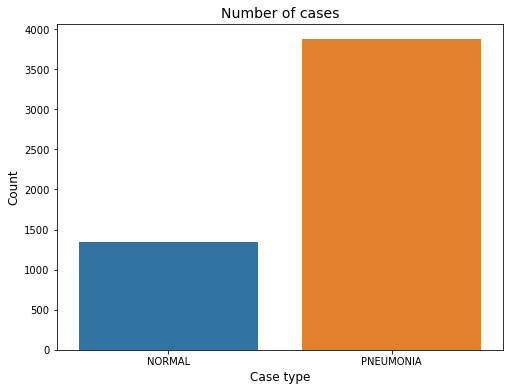

In [49]:
normal = list(train_data_dir.glob('NORMAL/*'))
pneumonia= list(train_data_dir.glob('PNEUMONIA/*'))

plt.figure(figsize=(8,6))
sns.barplot(x=CLASS_NAMES, y= [len(normal), len(pneumonia)])
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

As shown above, the data is highly imbalanced. We have almost the thrice pneumonia here as compared to the normal cases. This situation is normal when it comes to the medical data. We will either see more positive or negative cases.

## Data Augmentation

Data augmentation is a powerful technique which helps in almost every case for improving the robustness of a model. But augmentation is much more helpful where the dataset is imbalanced. We can generate different samples of undersampled class in order to try to balance the overall distribution.

I am using Keras ImageDataGenerator class for data augmentation.

In [ ]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                  zoom_range = 0.2, 
                                  horizontal_flip = True, 
                                  rotation_range=30,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2)
val_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale = 1./255)

#### Using Keras flow_from_directory method to read and preprocess images

In [73]:

train_it = train_datagen.flow_from_directory(directory = str(train_data_dir), 
                                       class_mode='binary', shuffle = True,
                                       target_size = (IMG_HEIGHT, IMG_WIDTH),
                                       color_mode='grayscale',
                                       batch_size=BATCH_SIZE)
val_it = val_datagen.flow_from_directory(directory = str(val_data_dir), 
                                       class_mode='binary', shuffle = True,
                                       target_size = (IMG_HEIGHT, IMG_WIDTH),
                                       color_mode='grayscale',  
                                       batch_size=BATCH_SIZE)
test_it = test_datagen.flow_from_directory(directory = str(test_data_dir), class_mode='binary',
                                      shuffle = False,
                                      target_size = (IMG_HEIGHT, IMG_WIDTH),
                                      color_mode='grayscale',     
                                      batch_size=BATCH_SIZE)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Visualizing the Data

In [31]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15,15))     
    for n in range(8):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1])
        plt.axis('off')

#### Here are 8 images from both classes

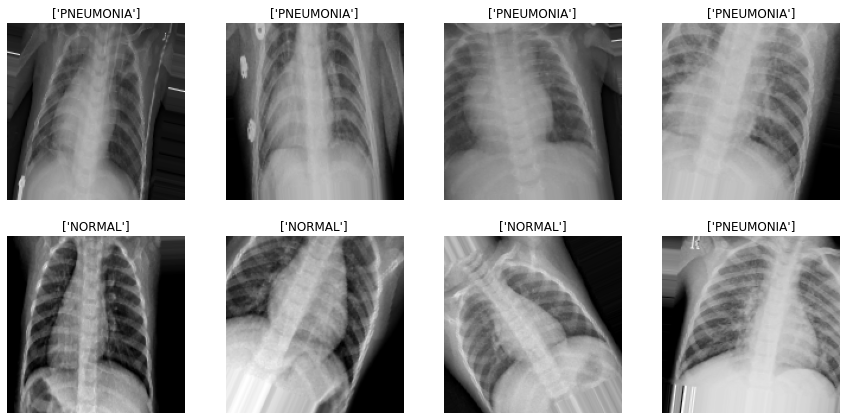

In [32]:
image_batch, label_batch = next(train_it)
show_batch(image_batch, label_batch)

## Model

In [74]:
def custom_model(INPUT_SHAPE = (150,150,1)):

    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = INPUT_SHAPE))
    model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 256 , activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 1 , activation = 'sigmoid'))

    return model

In [75]:
model = custom_model(INPUT_SHAPE = (150,150,1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 38, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 19, 19, 128)      

In [76]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = opt, loss='binary_crossentropy', metrics = ['accuracy'])
                                                 

In [13]:
history = model.fit(train_it, steps_per_epoch = STEPS_PER_EPOCH,
                    validation_data= val_it,
         epochs = 30)

Epoch 1/30
163/163 [==============================] - 54s 333ms/step - loss: 0.5825 - accuracy: 0.7410 - val_loss: 0.7744 - val_accuracy: 0.5000
Epoch 2/30
163/163 [==============================] - 60s 368ms/step - loss: 0.4673 - accuracy: 0.7772 - val_loss: 0.9432 - val_accuracy: 0.5625
Epoch 3/30
163/163 [==============================] - 59s 361ms/step - loss: 0.3319 - accuracy: 0.8499 - val_loss: 0.7212 - val_accuracy: 0.6875
Epoch 4/30
163/163 [==============================] - 59s 360ms/step - loss: 0.3011 - accuracy: 0.8660 - val_loss: 1.7718 - val_accuracy: 0.5000
Epoch 5/30
163/163 [==============================] - 59s 360ms/step - loss: 0.2792 - accuracy: 0.8735 - val_loss: 1.1005 - val_accuracy: 0.6250
Epoch 6/30
163/163 [==============================] - 59s 361ms/step - loss: 0.2505 - accuracy: 0.8944 - val_loss: 0.8307 - val_accuracy: 0.6875
Epoch 7/30
163/163 [==============================] - 58s 355ms/step - loss: 0.2492 - accuracy: 0.8955 - val_loss: 1.0514 - val_ac

## Analysis after Model Training

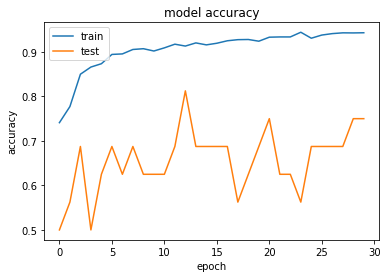

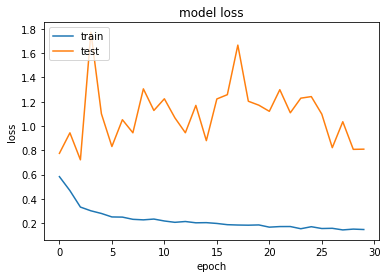

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## Running the model on test data

In [15]:
preds = model.evaluate(test_it)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

20/20 [==============================] - 10s 502ms/step
Loss = 0.020731499418616295
Test Accuracy = 0.9038461446762085


In [50]:
print("Test Accuracy: " +str(preds[1]*100) +"%")

Test Accuracy: 90.384%


In [17]:
Prediction = model.predict(
    test_it, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10,
    workers=1, use_multiprocessing=False)

In [ ]:
pred_class_indices = np.empty([len(Prediction),1])
for i in range(len(Prediction)):
    if Prediction[i,:] >= 0.5:
        pred_class_indices[i] = 1
    else:
        pred_class_indices[i] = 0

## F1 Score

In [78]:
predictions = pred_class_indices.reshape(1,-1)[0].astype(int)
print(classification_report(test_it.classes, predictions, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.95      0.77      0.85       234
Pneumonia (Class 1)       0.88      0.97      0.92       390

           accuracy                           0.90       624
          macro avg       0.91      0.87      0.89       624
       weighted avg       0.90      0.90      0.90       624



F1 score shows 97% recall for Pneumonia class, which means our classifier caught 97% of positive Pneumonia cases.  

## Confusion Matrix

[[181  53]
 [ 10 380]]


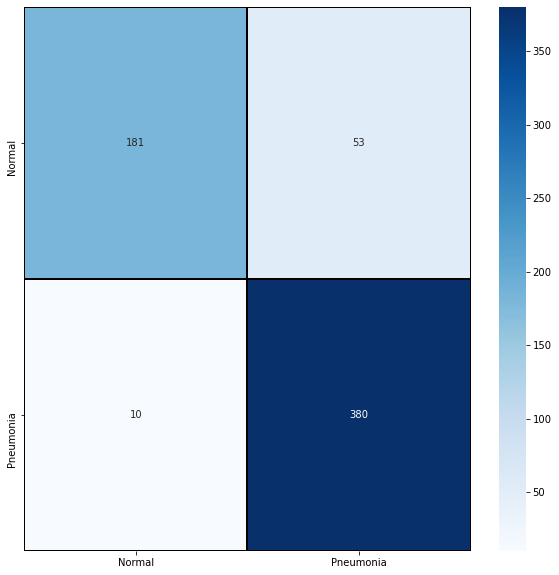

In [80]:
cm = confusion_matrix(test_it.classes, predictions)
print(cm)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", xticklabels = ['Normal','Pneumonia'], 
           yticklabels = ['Normal','Pneumonia'], linecolor = 'black' , linewidth = 1 , annot = True, fmt='')